Verfügbare Variablen: dict_keys(['__header__', '__version__', '__globals__', 'val'])
Dimensionen der Signale: (1, 4, 1500)


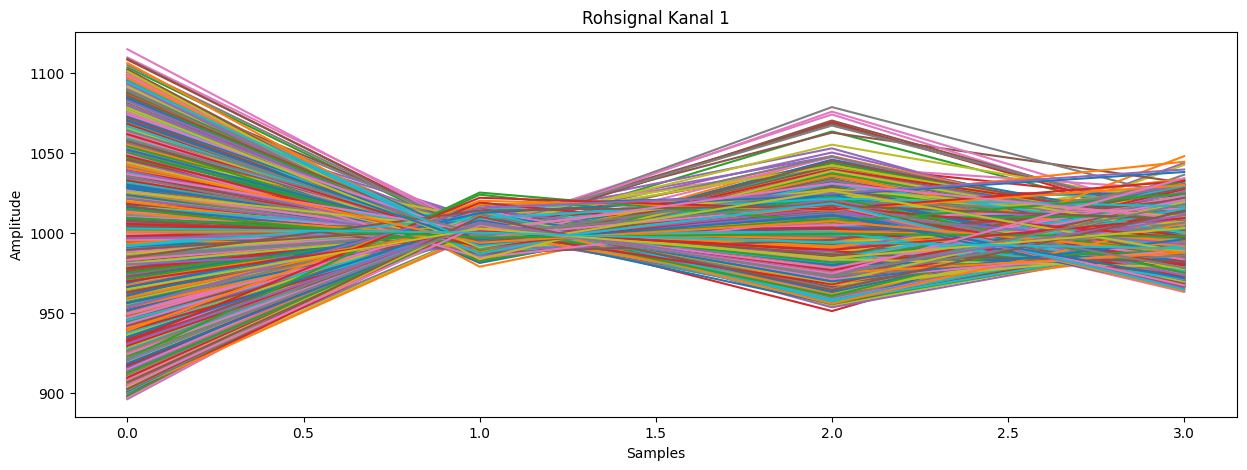

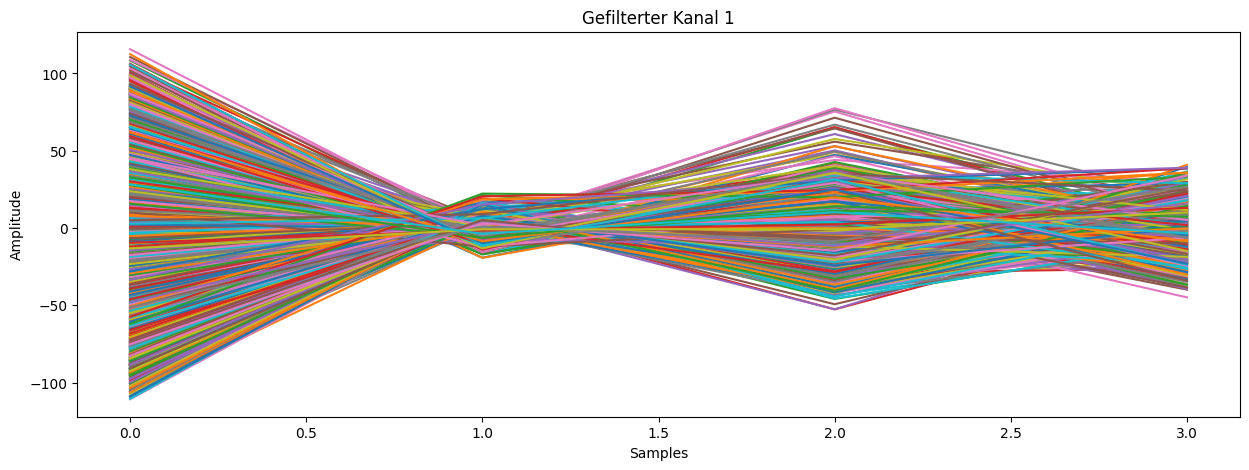

ValueError: Found array with dim 3. FastICA expected <= 2.

In [18]:
# Importieren der benötigten Bibliotheken
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.decomposition import FastICA

# ----------------------------
# Schritt 1: Daten laden
# ----------------------------

# Pfad zur .mat Datei angeben
# Hier verwenden wir die Datei '000.mat' aus dem Ordner 'heartbeat_data'
data = scipy.io.loadmat('heartbeat_data/000.mat')

# Zugriff auf die Signaldaten in der Variablen 'val'
# Überprüfen der verfügbaren Variablen in der Datei
print('Verfügbare Variablen:', data.keys())

# Die Signale befinden sich in der Variablen 'val'
signale = data['val']

# Überprüfen der Dimensionen der Signaldaten
print('Dimensionen der Signale:', signale.shape)
# Erwartet wird eine Form von (Anzahl_Kanäle, Anzahl_Samples)

# ----------------------------
# Schritt 2: Rohsignale plotten
# ----------------------------

# Plotten jedes Kanals
for i in range(signale.shape[0]):
    plt.figure(figsize=(15, 5))
    plt.plot(signale[i])
    plt.title(f'Rohsignal Kanal {i+1}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

# ----------------------------
# Schritt 3: Bandpassfilterung
# ----------------------------

# Funktion zur Bandpassfilterung definieren
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Führt eine Bandpassfilterung auf den Daten durch.

    Parameters:
    - data: Eingangssignal
    - lowcut: untere Grenzfrequenz
    - highcut: obere Grenzfrequenz
    - fs: Abtastrate
    - order: Filterordnung

    Returns:
    - Gefiltertes Signal
    """
    nyquist = 0.5 * fs  # Nyquist-Frequenz
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')  # Butterworth-Bandpassfilter
    y = filtfilt(b, a, data)  # Filterung des Signals
    return y

# Filterparameter festlegen
lowcut = 0.5   # Untere Grenzfrequenz in Hz
highcut = 100.0  # Obere Grenzfrequenz in Hz
fs = 360  # Abtastrate in Hz (für synthetische Daten)

# Filter auf jeden Kanal anwenden
gefilterte_signale = []
for i in range(signale.shape[0]):
    gefiltertes_signal = bandpass_filter(signale[i], lowcut, highcut, fs)
    gefilterte_signale.append(gefiltertes_signal)

# Gefilterte Signale in ein NumPy-Array umwandeln
gefilterte_signale = np.array(gefilterte_signale)

# Gefilterte Signale plotten
for i in range(gefilterte_signale.shape[0]):
    plt.figure(figsize=(15, 5))
    plt.plot(gefilterte_signale[i])
    plt.title(f'Gefilterter Kanal {i+1}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()
# ----------------------------
# Schritt 4: Independent Component Analysis (ICA)
# ----------------------------

# Daten für ICA vorbereiten
# Transponieren, um die Form [Anzahl_Samples, Anzahl_Kanäle] zu erhalten
X = gefilterte_signale.T

# Dimensionen überprüfen
print("Dimensionen von X (nach Transponierung):", X.shape)

# ICA anwenden
ica = FastICA(n_components=gefilterte_signale.shape[0], random_state=42)
S_ = ica.fit_transform(X)  # Rekonstruierte Signale (unabhängige Komponenten)
A_ = ica.mixing_  # Mischmatrix

# Form der unabhängigen Komponenten überprüfen
print('Form der unabhängigen Komponenten:', S_.shape)


# Unabhängige Komponenten plotten
for i in range(S_.shape[1]):
    plt.figure(figsize=(15, 5))
    plt.plot(S_[:, i])
    plt.title(f'Unabhängige Komponente {i+1}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

# ----------------------------
# Schritt 5: Spitzen (Peaks) finden und Herzfrequenz berechnen
# ----------------------------

# Spitzen in den unabhängigen Komponenten finden und Herzfrequenz berechnen
herzfrequenzen = []
komponenten = []

for i in range(S_.shape[1]):
    komponent = S_[:, i]
    # Spitzen finden
    peaks, _ = find_peaks(komponent, distance=fs*0.3)  # Mindestabstand 0.3 Sekunden (entspricht ~200 bpm)
    # Intervall zwischen den Spitzen berechnen
    intervals = np.diff(peaks)
    if len(intervals) == 0:
        continue  # Keine Spitzen gefunden, nächste Komponente
    herzfrequenz = 60 * fs / intervals  # in bpm
    avg_hr = np.mean(herzfrequenz)
    herzfrequenzen.append(avg_hr)
    komponenten.append(komponent)
    print(f'Komponente {i+1}: Durchschnittliche Herzfrequenz = {avg_hr:.2f} bpm')
    # Plotten der Komponente mit erkannten Spitzen
    plt.figure(figsize=(15, 5))
    plt.plot(komponent)
    plt.plot(peaks, komponent[peaks], 'rx')
    plt.title(f'Unabhängige Komponente {i+1} mit erkannten Spitzen')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

# ----------------------------
# Schritt 6: Auswahl der fetalen Komponente und Anomalien erkennen
# ----------------------------

# Basierend auf den durchschnittlichen Herzfrequenzen wählen wir die Komponente mit der fetalen Herzfrequenz aus
# Annahme: Die Komponente mit einer durchschnittlichen Herzfrequenz zwischen 110 und 160 bpm ist das fetale EKG

# Suche nach der fetalen Komponente
fetale_indexe = [i for i, hr in enumerate(herzfrequenzen) if 110 <= hr <= 160]

if fetale_indexe:
    index = fetale_indexe[0]
    fetale_komponente = komponenten[index]
    fetale_hr = herzfrequenzen[index]
    print(f'Fetale Komponente gefunden: Komponente {index+1} mit durchschnittlicher Herzfrequenz {fetale_hr:.2f} bpm')

    # Spitzen in der fetalen Komponente finden
    peaks, _ = find_peaks(fetale_komponente, distance=fs*0.3)
    intervals = np.diff(peaks)
    fetale_hf = 60 * fs / intervals

    # Plotten der fetalen Herzfrequenz über die Zeit
    plt.figure()
    plt.plot(fetale_hf)
    plt.title('Fetale Herzfrequenz über Zeit')
    plt.xlabel('Schlagnummer')
    plt.ylabel('Herzfrequenz (bpm)')
    plt.show()

    # Anomalien erkennen (Herzfrequenz außerhalb des normalen Bereichs)
    abnormale_schläge = np.where((fetale_hf < 110) | (fetale_hf > 160))[0]

    if len(abnormale_schläge) > 0:
        print("Abnormale fetale Herzschläge erkannt. Empfehlung: Genauere Untersuchung dieser Segmente.")
    else:
        print("Keine Anomalien in der fetalen Herzfrequenz erkannt.")
else:
    print("Keine fetale Komponente gefunden.")

    # Sicherstellen, dass gefilterte_signale die richtige Dimension hat
print("Dimensionen von gefilterte_signale:", gefilterte_signale.shape)






